In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')


In [3]:
df = pd.read_csv("../data/listings.csv")

# Clean price
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df.dropna(subset=['price', 'latitude', 'longitude'], inplace=True)

# Feature engineering (same as before)
df['num_amenities'] = df['amenities'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
df['host_tenure_days'] = (pd.Timestamp('2025-08-01') - df['host_since']).dt.days
df['description_length'] = df['description'].apply(lambda x: len(str(x).split()))

albany_center = (42.6526, -73.7562)
df['distance_from_center'] = np.sqrt(
    (df['latitude'] - albany_center[0])**2 + (df['longitude'] - albany_center[1])**2
)

# Select features
features = ['num_amenities', 'host_tenure_days', 'description_length',
            'distance_from_center', 'latitude', 'longitude', 'room_type']

df_model = df[features + ['price']].dropna()
df_model.head()


,num_amenities,host_tenure_days,description_length,distance_from_center,latitude,longitude,room_type,price
0,8,4589,27,0.005851,42.65789,-73.75370,Entire home/apt,70.0
1,37,4012,85,0.011047,42.65222,-73.76724,Entire home/apt,104.0
2,33,3794,69,0.007319,42.64615,-73.75966,Entire home/apt,75.0
3,32,4012,81,0.011047,42.65222,-73.76724,Entire home/apt,101.0
4,33,4043,61,0.009351,42.65559,-73.76506,Entire home/apt,110.0


In [4]:
X = df_model.drop('price', axis=1)
y = df_model['price']

cat_cols = ['room_type']
num_cols = X.columns.difference(cat_cols)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

X_processed = preprocessor.fit_transform(X)
print("Feature shape:", X_processed.shape)


Feature shape: (419, 8)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)


In [6]:
input_dim = X_train.shape[1]

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(input_dim,)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)  # Regression output
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,473 (37.00 KB)

 Trainable params: 9,473 (37.00 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 23559.2344 - mae: 115.8774 - val_loss: 24898.4473 - val_mae: 122.5568
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 23237.6895 - mae: 114.5779 - val_loss: 24535.0156 - val_mae: 121.0278
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 22796.3887 - mae: 112.7515 - val_loss: 24027.8477 - val_mae: 118.8628
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 22198.7520 - mae: 110.3097 - val_loss: 23319.6465 - val_mae: 115.7740
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 21272.8145 - mae: 106.5489 - val_loss: 22359.7148 - val_mae: 111.4365
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 20159.7129 - mae: 101.5411 - val_loss: 21097.0469 - val_mae: 105.4401
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 18662.2656 - mae: 94.2575 - val_loss: 19541.6641 - val_mae: 97.4742
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 16904.9707 - mae: 85.5133 - val_loss: 17

In [8]:
preds = model.predict(X_test).flatten()

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
MAE: 51.44
RMSE: 95.42
R²: 0.08


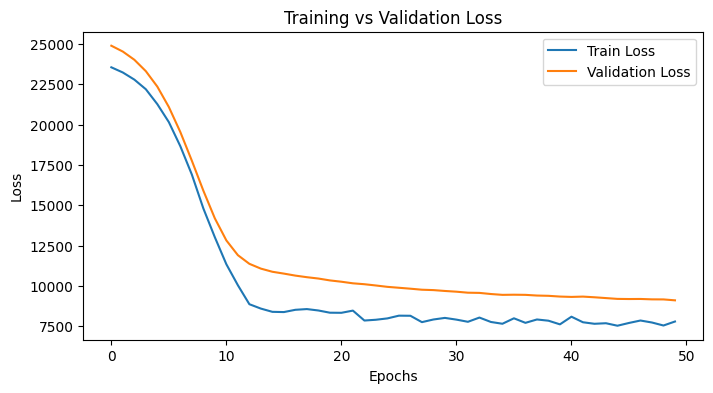

In [9]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("../figures/deep_learning_loss.png")
plt.show()
